# 5.2 線形判別分析(LDA)による教師ありデータ圧縮
- LDAは、計算効率を高め、正則化されていないモデルで「次元の呪い」による過学習を抑制するために使用できる。
- LDAはクラスの分離を最適化する特徴部分空間を見つけ出そうとする。
- LDAは教師ありアルゴリズムであるため、分類タスクの特徴抽出の手段としては、LDAの方が優れている。
- LDAではデータが正規分布に従っていることが前提である。
- LDAではクラスの共分散行列がまったく同じであることが前提である。
- LDAでは特徴量が統計的に見て互いに独立していることも前提となる。
- 以上の3つの前提を多少満たしていなくとも、次元削減の手段としてのLDAはそれなりにうまく行く
- LDAのアプローチの主な手順についてまとめる

１．d次元のデータセットを標準化する

２．クラスごとにd次元の平均ベクトルを計算する

３．クラス間変動行列$\vec{S}_{B}$と、クラス内変動行列$\vec{S}_{W}$を生成する

４．行列$\vec{S}^{-1}_{W} \vec{S}_{B}$の固有ベクトルと対応する固有値を計算する

５．$d\times k$次元の変換行列$\vec{W}$を生成するために、最も大きいk個の固有値に対応するk個の固有ベクトルを選択する。固有ベクトルは、この行列の列である。

６．変換行列$\vec{W}$を使ってサンプルを新しい特徴部分空間へ射影する。

# 5.2.1 変動行列を計算する
- 平均ベクトルを計算する。
- 各平均ベクトル$\vec{m}_{i}$には、クラス$i$のサンプルに関する平均特徴量の値$\mu_{m}$が格納される。
$$\vec{m}_{i} = \frac{1}{n_{i}} \sum_{\vec{x} \in D_{i}} \vec{x}$$
- 平均ベクトルを用いて、クラス内変動行列とクラス間変動行列を生成する。

- wineデータセットの例では、以下の平均ベクトルが3つ得られる。
$$\vec{m}_{i} = \begin{bmatrix} \mu_{i,alcohol} \\ \mu_{i,malic acid} \\ \vdots \\ \mu_{i,proline} \end{bmatrix} \, i\in (1,2,3)$$ 

In [4]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df_wine.iloc[:,1:].values ,df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
import numpy as np

np.set_printoptions(precision=4)
mean_vecs = []

for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label],axis=0))
    print('MV %s: %s\n') %(label,mean_vecs[label-1])

MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



- 平均ベクトルを使ってクラス内変動行列$S_{W}$を計算する方法は以下のようになる
$$\vec{S}_{W} = \sum^{c}_{i=1} \vec{S}_{i}$$
$$\vec{S}_{i} = \sum_{\vec{x} \in D_{i}}(\vec{x} - \vec{m}_{i})(\vec{x}-\vec{m}_{i})^{T}$$

In [6]:
d = 13 #特徴量の個数
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row,mv = row.reshape(d,1),mv.reshape(d,1) #list of listに変換
        class_scatter += (row-mv).dot((row-mv).T)
    S_W += class_scatter

print('within-class scatter matrix: %sx%s') % (S_W.shape[0],S_W.shape[1])

within-class scatter matrix: 13x13


- 変動行列を計算するときには、トレーニングデータセットにおいてクラスラベルが一様に分布していることが前提となる。このデータセットでは、この前提を満たしていない。

In [7]:
print('Class label distribution: %s') %np.bincount(y_train)[1:]

Class label distribution: [40 49 35]


- 個々の変動行列$\vec{S}_{i}$を合計して変動行列$\vec{S}_{W}$を生成する前に、スケーリングが必要となる。
- 変動行列をクラスごとのサンプルの個数$N_{i}$で割るときに、変動行列の計算が実は共分散行列の計算と同じであることがわかる。
- 共分散行列は変動行列の正規化バージョンである。
$$\sum_{i} = \frac{1}{N_{i}}\vec{S}_{W} = \frac{1}{N_{i}}\sum_{\vec{x} in D_{i}} (\vec{x}-\vec{m}_{i})(\vec{x}-\vec{m}_{i})^{T}$$

In [8]:
d = 13 #特徴量の個数
S_W = np.zeros((d,d))
for label,mv in zip(range(1,4),mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
    
print('Scaled within-class scatter matrix: %sx%s') % (S_W.shape[0],S_W.shape[1])
    

Scaled within-class scatter matrix: 13x13


- クラス間変動行列$S_{B}$の計算
- $\vec{m}$はすべてのクラスのサンプルを対象として計算される全体平均である
$$\vec{S}_{B} = \sum^{c}_{i=1} N_{i}(\vec{m}_{i}-\vec{m})(\vec{m}_{i}-\vec{m})^{T}$$

In [10]:
mean_overall = np.mean(X_train_std,axis=0)
d = 13 # 特徴量の個数
S_B = np.zeros((d,d))
for i,mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s') %(S_B.shape[0],S_B.shape[1])

Between-class scatter matrix: 13x13


# 5.2.2 新しい特徴部分空間の線形判別を選択する
- 行列$\vec{S}^{-1}_{W}\vec{S}_{B}$の一般化された固有値問題を解く

In [12]:
# inv関数で逆行列,dot関数で行列積、eig関数で固有値問題を計算
eigen_vals,eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [14]:
eigen_pairs = [(np.abs(eigen_vals[i]),eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,key=lambda k:k[0],reverse=True) #lambdaでindex0の値（固有値）でソート
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
1.09631693658e-13
5.00326869474e-14
3.23670030581e-14
3.23670030581e-14
2.68392961047e-14
1.61264149918e-14
1.57376098252e-14
1.36543690102e-14
1.36543690102e-14
1.41523083537e-15
1.41523083537e-15


- クラス間変動行列$\vec{S}_{B}$は階数（ランク）１以下のc個の行列を合計したものである。
- このため、クラスラベルの個数をcとすれば、LDAでの線形半越の個数は最大でc-1個となる。
- 計算結果では、0ではない固有値は２個しか無い

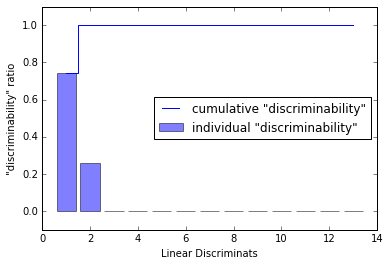

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
#線形判別をプロットする。
#固有値の実数部の総和を求める。
tot = sum(eigen_vals.real)
#分散説明率とその累積和を計算
discr = [(i / tot) for i in sorted(eigen_vals.real,reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1,14),discr,alpha=0.5,align='center',label='individual "discriminability"')
plt.step(range(1,14),cum_discr,where='mid',label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminats')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.show()

In [24]:
#２つの固有ベクトルから、変換行列を作成
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real,eigen_pairs[1][1][:,np.newaxis].real))
print('matrix W:\n%s') %w

matrix W:
[[-0.0662  0.3797]
 [ 0.0386  0.2206]
 [-0.0217  0.3816]
 [ 0.184  -0.3018]
 [-0.0034 -0.0141]
 [ 0.2326 -0.0234]
 [-0.7747 -0.1869]
 [-0.0811 -0.0696]
 [ 0.0875 -0.1796]
 [ 0.185   0.284 ]
 [-0.066  -0.2349]
 [-0.3805 -0.073 ]
 [-0.3285  0.5971]]


# 5.2.3 新しい特徴空間にサンプルを射影する
- 変換行列$\vec{W}$に行列を掛けることにより、トレーニングデータ・セットを変換する。
$$\vec{X}^{'} = \vec{X}\vec{W}$$

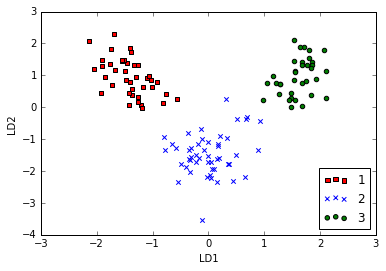

In [34]:
# 標準化したトレーニングデータに変換号列を掛ける
X_train_lda = X_train_std.dot(w)
colors = ['r','b','g']
markers = ['s','x','o']
for l,c,m in zip(np.unique(y_train),colors,markers):
    plt.scatter(X_train_lda[y_train==l,0],X_train_lda[y_train==l,1],c=c,marker=m,label=l)

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.show()

- 新しい特徴部分空間では、3つのクラスが完全に線形分離となる。

# 5.2.4 scikit-learnによるLDA

In [36]:
from sklearn.lda import LDA
#次元数を指定して、LDAのインスタンスを生成
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std,y_train)

- ロジスティック回帰の分類器がLDAによって変換された低次元のトレーニングデータセットをどのように処理するか見る

In [37]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,resolution=0.02):
    
    #マーカとカラーマップの準備
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','grey','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #決定領域のプロット
    x1_min,x1_max = X[:,0].min() - 1,X[:,0].max() + 1
    x2_min,x2_max = X[:,1].min() - 1,X[:,1].max() + 1
    
    #グリッドポイントの生成
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    
    #各特徴量を１次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    #グリッドポイントの等高線のプロット
    plt.contourf(xx1,xx2,Z,alpha=0.4,cmap=cmap)
    #軸の範囲の設定
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    #クラスごとにサンプルをプロット
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],y=X[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)

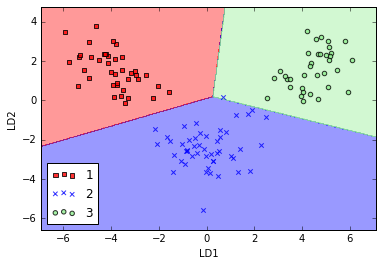

In [39]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda,y_train)
plot_decision_regions(X_train_lda,y_train,classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

- 誤分類は１つ
- 正則化の強さを下げれば決定境界をずらすことができるため、ロジスティック回帰モデルがトレーニングデータセットのサンプルを正しく分類するようになるだろう

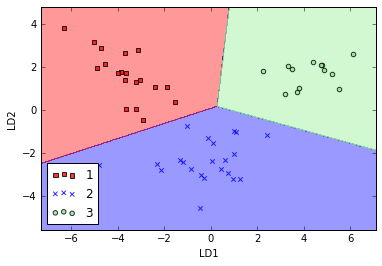

In [40]:
#テストデータ・セットでの結果
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda,y_test,classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.show()

- ロジスティック回帰の分類器は、Wineデータセットの元の13個の特徴量ではなく、２次元の特徴部分空間だけを使用することにより、テストデータセットのサンプルを完全な精度で分類できることがわかる。